In [1]:
import torch

def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

device = get_device()

No GPU available, using the CPU instead.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [3]:
if IN_COLAB:
    PATH_TO_DATA = '/content/'
else:
    PATH_TO_DATA = './data/'

In [9]:
import numpy as np

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [5]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [13]:
encoder_name = 'timm-efficientnet-b0'

In [38]:
scheduler_params = dict(
    name = 'MultiStepLR', # MultiStepLR OneCycleLR None

    # MultiStepLR
    milestones = [1, 2, 3],
    gamma = 0.5,
)

debug_params = dict(
    reduce_train=True,
    train_number=20,
    valid_number=4,

    batch_size_train=2,
    batch_size_valid=2,
    max_iter=5,
    unfreeze_iter=0,
    valid_iters=[1, 3, 4],
    
    scheduler_params=scheduler_params,
    
    encoder_name = encoder_name,
    save_model=True,
    model_save_name='test_model',
)

In [10]:
max_iter=480
valid_step=30
unfreeze_iter=0 # 90

valid_iters = list(np.arange(valid_step-1, max_iter, valid_step))
valid_iters

[29, 59, 89, 119, 149, 179, 209, 239, 269, 299, 329, 359, 389, 419, 449, 479]

In [15]:
scheduler_params = dict(
    name = 'None', # MultiStepLR OneCycleLR None

    # MultiStepLR
    milestones = [300],
    gamma = 0.4,
    
    # OneCycleLR
    max_lr = 0.3,
    pct_start = 0.3,
)

full_params = dict(
    reduce_train=False,
    train_number=0,
    valid_number=0,
    
    batch_size_train=32,
    batch_size_valid=32,
    max_iter=max_iter,
    unfreeze_iter=unfreeze_iter,
    # valid_iters=valid_iters
    
    scheduler_params=scheduler_params,
    
    encoder_name=encoder_name,
    save_model=True,
    model_save_name=f'unet_{encoder_name}_V2_10.09'
)

In [39]:
params = dict(
    path_to_data=PATH_TO_DATA,

    optimizer_name='Adam',
    learning_rate=3e-4, # 5e-4, 3e-4, 1e-3
    weight_decay=0,

    verbose=True
)

params.update(debug_params) # full_params, debug_params

In [40]:
params

{'path_to_data': './data/',
 'optimizer_name': 'Adam',
 'learning_rate': 0.0003,
 'weight_decay': 0,
 'verbose': True,
 'reduce_train': True,
 'train_number': 20,
 'valid_number': 4,
 'batch_size_train': 2,
 'batch_size_valid': 2,
 'max_iter': 5,
 'unfreeze_iter': 0,
 'valid_iters': [1, 3, 4],
 'scheduler_params': {'name': 'MultiStepLR',
  'milestones': [1, 2, 3],
  'gamma': 0.5},
 'encoder_name': 'timm-efficientnet-b0',
 'save_model': True,
 'model_save_name': 'test_model'}

In [41]:
from main import run_cv

In [42]:
train_infos = run_cv(device, **params)

[run_cv]

[data] fold: 0, flood_ids: ['kuo', 'tht', 'qus']
[data] Dataset size, train: 417, valid: 125, ratio: 23.062730627306273
[data] Reduced dataset size, train: 20, valid: 4
[data] DataLoader size, train: 10, valid: 2
[data] num_epoch: 0.5, num_train_samples: 10
[train] started...
[train] iter:    1, loss = 0.79472, score = 0.39158, time: 0:00:06
[valid] iter:    1, loss = 0.04835, score = 0.00000, time: 0:00:06
[valid] iter:    1, score = {'kuo': 0.0}

[train] iter:    3, loss = 0.76037, score = 0.25344, time: 0:00:12
[valid] iter:    3, loss = 0.04290, score = 0.00000, time: 0:00:12
[valid] iter:    3, score = {'kuo': 0.0}

[train] iter:    4, loss = 0.75075, score = 0.24698, time: 0:00:17
[valid] iter:    4, loss = 0.04615, score = 0.00000, time: 0:00:17
[valid] iter:    4, score = {'kuo': 0.0}

[valid] best score = 0.00000, iter:    0
[train] finished for: 0:00:17

[data] fold: 1, flood_ids: ['hxu', 'hbe', 'awc']
[data] Dataset size, train: 432, valid: 110, ratio: 20.295202952

In [30]:
len(train_infos)

4

In [33]:
from plot_utils import show_train_metrics, show_loss_and_score, show_valid_score_by_flood

In [34]:
train_info = train_infos[0]

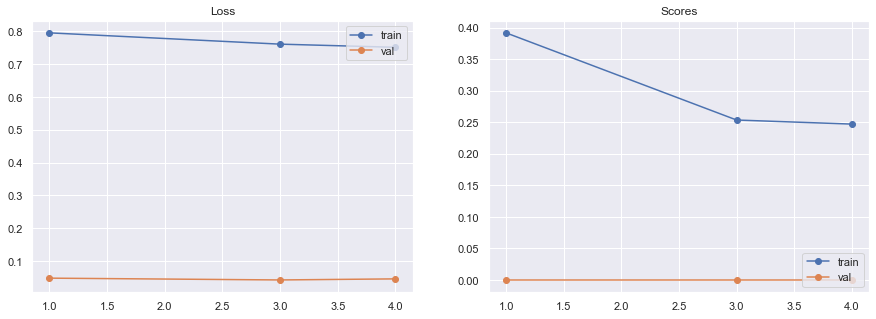

In [35]:
show_loss_and_score(train_info)

TypeError: 'function' object is not subscriptable

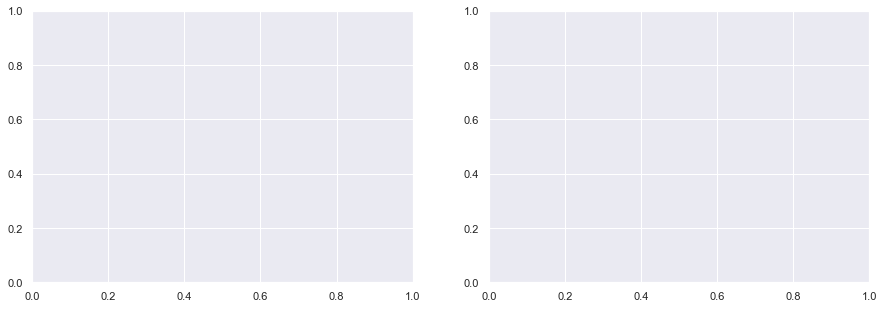

In [36]:
show_loss_and_score(show_valid_score_by_flood)

In [43]:
# loss_meter = train_info['train_loss_meter']
# score_meter = train_info['train_score_meter']
# show_train_metrics(loss_meter, score_meter)